# Determining Concentration-Dependent Viscosity Behavior Using Intrinsic Viscosity

### 0.5 Connect your Google Drive

Run the segment belowe and follow the instructions it gives you. This will allow you to access files in your Google Drive, where you should store the excel file that contains your data.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

### 1. Import Statements

This cell must be executed at the beginning of every run.

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import math
import sklearn.linear_model as sklm
import random
import itertools
import scipy

from matplotlib.animation import FuncAnimation
from numpy.polynomial.polynomial import polyfit
from scipy.optimize import curve_fit
from itertools import chain
from prettytable import PrettyTable

### 2. Importing Viscosity Data

This cell imports viscosity data from an excel spreadsheet. Replace the part between the quotes with the path to the excel file. Do NOT remove the r in front of the quotes.

The notebook requires that the data be formatted in a specific way:

<pre>
Molecule Name | Buffer Name
  C (mg/mL)   |    V (cP)
     ###      |     ###
</pre>

The "C" and "V" must actually be a cell with just those letters in it. It signals to the notebook that the data in the column is either concentration data or viscosity data.

It does not matter whether the concentration data is ascending/descending/random order, as long as it lines up with the corresponding viscosity data.

One of the data points MUST be a measurement of buffer viscosity, which should be entered as a concentration of 0.'

In [0]:
curves = pd.read_excel(r'C:\Users\eepstein\Documents\Curves.xlsx')

### 3. Methods

Defines several of the methods used later on in the notebook. Nothing to change here, needs to be executed as is at the beginning of each run

In [0]:
#Calculates the reduced chi-squared statistic for a fit and a set of experimental data. This will be used to assess
#the validty of both the experimental fit and the model
def stats(y_exp,y_model):
    y_exp = np.asarray(y_exp) #experimental y-values
    y_model = np.asarray(y_model) #modeled y-values
    
    var = np.var(y_exp) #variance within the experimental values

    chi_squared = np.sum(((y_exp-y_model)**2)/(var**2))
    dof = len(y_exp) - 3
    
    return(chi_squared/dof)

#Creates a linear fit for the x and y data inputted. -Only used if the robust fit doesn't work-
def fit(x,y,title,legend,Print = True):
    
    #Uses a pre-established method for fitting the data
    fit = np.polyfit(x,y,1)
    
    #plots the intrinsic viscosity graph unless Print is answered as False
    if(Print):
        plt.rcParams["figure.figsize"] = [12,9]
        plt.rcParams.update({'font.size': 22})
        plt.scatter(x,y)
        c = np.linspace(0,30)
        plt.plot(c, np.poly1d(fit)(c),label=legend)
        plt.ylabel("Viscosity")
        plt.xlabel("Concentration (mg/mL)")
        plt.xlim(0,50)
        plt.title(title)
        plt.legend()
    
    return fit;

#Creates a robust fit for the x and y data inputted.
def fit_rob(x,y,title,legend,Print = True):
    x = np.array(x)
    
    xt = x.reshape(-1,1)
    
    robreg = sklm.HuberRegressor()
    rfit = robreg.fit(xt,y)
    
    c = np.linspace(0,30)
    y2 = robreg.predict(c.reshape(-1,1))
        
    #Plots the intrinsic viscosity graph if Print = False
    if(Print):
        plt.rcParams["figure.figsize"] = [12,9]
        plt.rcParams.update({'font.size': 22})
        plt.scatter(x,y)
        plt.ylabel("Viscosity")
        plt.xlabel("Concentration (mg/mL)")

        plt.plot(c,y2,'--',label=legend) 
        plt.xlim(0,30)
        plt.title(title)
        plt.legend()
    
    return(robreg.intercept_)

#Calculates the viscosity for a given concentrations.
#c is concentration, solvisc is the solvent viscosity, y is the intrinsic viscosity, x is a fitting parameter
def model(c,solvisc,x,y):
    return solvisc*np.exp(y*c/(1-x*c))

#Calculates the concentration corresponding to a given viscosity.
#v is viscosity, solvisc is the solvent viscosity, y is the intrinsic viscosity, x is a fitting parameter
def model_inv(v,solvisc,x,y):
    ln = math.log(v/solvisc)
    c = (ln/y)/(1+(x/y)*ln)
    return c

#Creates a summarizing table of all curves
def tabulate(allcurves, rank=True):
    raw_dict = {"int_visc":[],"model_10cp":[],"exp_10cp":[],"model_150":[],"exp_150":[],"model_15cp":[],
                "exp_15cp":[],"model_175":[], "exp_175": [],"model_200":[],"exp_200":[]}

    for x in allcurves:
        #Add a dictionary of molecules to intrinsic viscosities
        raw_dict["int_visc"].append({"{} in {}".format(x.molecule,x.buffer) : x.intrinsic_visc})

        #Add a dictionary of molecules to the concentration at which they hit 10cP, according to the Mooney model
        raw_dict["model_10cp"].append({"{} in {}".format(x.molecule,x.buffer) : x.c10_model})

        #Add a dictionary of molecules to the concentration at which they hit 10cP, according to the experimental data
        raw_dict["exp_10cp"].append({"{} in {}".format(x.molecule,x.buffer) : x.c10_exp})    

        #Add a dictionary of molecules to the viscosity at 150mg/mL, according to the Mooney model
        raw_dict["model_150"].append({"{} in {}".format(x.molecule,x.buffer) : x.model_150})

        #Add a dictionary of molecules to the viscosity at 150mg/mL, according to the experimental data
        raw_dict["exp_150"].append({"{} in {}".format(x.molecule,x.buffer) : x.exp_150})
        
        #Add a dictionary of molecules to the concentration at which they hit 15cP, according to the Mooney model
        raw_dict["model_15cp"].append({"{} in {}".format(x.molecule,x.buffer) : x.c15_model})
        
        #Add a dictionary of molecules to the concentration at which they hit 15cP, according to the experimental data
        raw_dict["exp_15cp"].append({"{} in {}".format(x.molecule,x.buffer) : x.c15_exp})
        
        #Add a dictionary of molecules to the viscosity at 175mg/mL, according to the Mooney model
        raw_dict["model_175"].append({"{} in {}".format(x.molecule,x.buffer) : x.model_175})

        #Add a dictionary of molecules to the viscosity at 175mg/mL, according to the experimental data
        raw_dict["exp_175"].append({"{} in {}".format(x.molecule,x.buffer) : x.exp_175})
        
        #Add a dictionary of molecules to the viscosity at 200mg/mL, according to the Mooney model
        raw_dict["model_200"].append({"{} in {}".format(x.molecule,x.buffer) : x.model_200})

        #Add a dictionary of molecules to the viscosity at 200mg/mL, according to the experimental data
        raw_dict["exp_200"].append({"{} in {}".format(x.molecule,x.buffer) : x.exp_200})


    rank_dict = dict()
    mol_number = 0

    for key,value in raw_dict.items():
        values = []
        for x in value:
            for k,v in x.items():
                values.append(v)
        array = np.array(values)
        temp = array.argsort()
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(len(array))
        rank_dict[key] = ranks
        mol_number = len(ranks)
    
    mol_features = []
    
    comp_dict = dict() 

    for x in range(mol_number):
        mol_features.append([])

    if(rank):
        for key, value in rank_dict.items():
            for i in range(mol_number):
                mol_features[i].append(value[i])

        i = 0        
        for x in allcurves:
            comp_dict["{} in {}".format(x.molecule,x.buffer)] = mol_features[i]
            i+=1
    else:
        for key, value in raw_dict.items():
            for i in range(mol_number):
                mol_features[i].append(round(np.array(list(value[i].values()))[0],4))
                
        i = 0        
        for x in allcurves:
            comp_dict["{} in {}".format(x.molecule,x.buffer)] = mol_features[i]
            i+=1

    table = PrettyTable()
    table.field_names = ["", "Intrinsic Visc", "10cP (Model)", "10cP (Exp)", "150mg/mL (Model)", "150mg/mL (Exp)"]
    table.add_row(["Best Value","Lowest","Highest","Highest","Lowest","Lowest"])
    
    table2 = PrettyTable()
    table2.field_names = ["","15cp (Model)","15cp (Exp)","175mg/mL (Model)", "175mg/mL (Exp)","200mg/mL (Model)","200mg/mL (Exp)"]
    table2.add_row(["Best Value","Highest","Highest","Lowest","Lowest","Lowest","Lowest"])
    
    for key, value in comp_dict.items():
            table.add_row([key, *value[:5]])
            table2.add_row([key, *value[5:]])
            
    print(table)
    print(table2)

#A "Curve" class that contains all the important information contained within a viscosity curve    
class Curve:
    def __init__(self, molecule,buffer,concentrations,viscosities,Print = True):
        
        self.index_buffer = -1
        
        self.low_range_conc = []
        self.low_range_visc = []
            
        for x in range(len(concentrations)):
            if(int(concentrations[x]) == 0):
                index_buffer = x
            elif(int(concentrations[x]) <= 30 and int(concentrations[x]) >= 9):
                self.low_range_conc.append(concentrations[x])
                self.low_range_visc.append(viscosities[x])
        
        self.molecule = str(molecule)
        self.buffer = str(buffer)
        self.concentrations = np.array(concentrations)
        self.viscosities = np.array(viscosities)
        self.solvisc = self.viscosities[self.index_buffer]
        self.max_conc = int(math.ceil(np.amax(self.concentrations) / 10.0)) * 10
        
        rel_visc = []
        self.red_visc = []
        self.log_rel_visc = []

        length = len(self.low_range_conc)

        for x in range(length):
            rel_visc.append(self.low_range_visc[x]/self.solvisc)
            self.red_visc.append((rel_visc[x]-1)/self.low_range_conc[x])
            self.log_rel_visc.append(np.log(rel_visc[x])/self.low_range_conc[x])
            
        
        if(len(self.low_range_visc)>=3):
            try:
                intrinsic_visc1 = fit_rob(self.low_range_conc,self.red_visc,"{} in {}".format(self.molecule,self.buffer),"Reduced Viscosity",Print=Print)
                intrinsic_visc2 = fit_rob(self.low_range_conc,self.log_rel_visc,"{} in {}".format(self.molecule,self.buffer), "Log(Relative Viscosity)",Print=Print)
                self.intrinsic_visc = (intrinsic_visc1+intrinsic_visc2)/2
        
            except Exception:
                intrinsic_visc1 = fit(self.low_range_conc,self.red_visc,"{} in {}".format(self.molecule,self.buffer),"Reduced Viscosity")[1]
                intrinsic_visc2 = fit(self.low_range_conc,self.log_rel_visc,"{} in {}".format(self.molecule,self.buffer), "Log(Relative Viscosity)")[1]
                self.intrinsic_visc = (intrinsic_visc1+intrinsic_visc2)/2
         
        
    
    def __str__(self):
        return "{} {} {} {}".format(self.molecule,self.buffer,self.concentrations,self.viscosities)
    
    #Plots the experimental data
    def experimental(self):
        plt.scatter(self.concentrations,self.viscosities, label="{} in {}".format(self.molecule,self.buffer))
        plt.legend(loc = 'upper left')
        plt.ylabel("Viscosity (cP)")
        plt.xlabel("Concentration (mg/mL)")
        plt.rcParams.update({'font.size': 22})
    
    #Generates a best fit line for the viscosity curve
    def generate_fit(self, toprint = False):
        if(self.intrinsic_visc < 0.01):
            epsilon = 0.0005 #variation allowed in the intrinsic viscosity during fitting
        else:
            epsilon = 0.01
        
        epsilon_solvisc = 0.01 #variation allowed in solvent viscosity during fitting
        epsilon_packingparam = 0.0001 #variation allowed in packing parameter during fitting
        
        packingparam = 1/640
        
        init = [self.solvisc,packingparam,self.intrinsic_visc]
        
        self.fitvars, covar = curve_fit(model,self.concentrations,self.viscosities,bounds=((self.solvisc-epsilon_solvisc,packingparam-epsilon_packingparam,self.intrinsic_visc-epsilon), (self.solvisc+epsilon_solvisc,packingparam+epsilon_packingparam,self.intrinsic_visc+epsilon)))
        
        c = np.linspace(0,self.max_conc)
        
        if(toprint):
            print("{} in {}:".format(self.molecule,self.buffer))
            print("Fit Solvent Viscosity: {}cP\nFit Packing Param:{}\nFit Intrinsic Viscosity: {}ml/mg\n".format(*self.fitvars))
#         else:        
#             y1 = 1.1*model(c,*self.fitvars)
#             y2 = 0.9*model(c,*self.fitvars)
#             y3 = 1.2*model(c,*self.fitvars)
#             y4 = 0.8*model(c,*self.fitvars)
#             plt.plot(c,y1,'r--',label="10% Error")
#             plt.plot(c,y2,'r--')
#             plt.plot(c,y3,'y--',label="20% Error")
#             plt.plot(c,y4,'y--')
        
        plt.plot(c,model(c,*self.fitvars),label="Fit: {} in {}".format(self.molecule,self.buffer))
        plt.legend(loc = 'upper left')
        plt.ylabel("Viscosity (cP)")
        plt.xlabel("Concentration (mg/mL)")
        plt.rcParams["figure.figsize"] = [12,9]
        plt.rcParams.update({'font.size': 22})
        
        lim = max(self.viscosities) + 10
        plt.ylim(0,lim)
        
        self.c10_exp = model_inv(10,*self.fitvars)
        self.c15_exp = model_inv(15,*self.fitvars)
        self.exp_150 = model(150,*self.fitvars)
        self.exp_175 = model(175,*self.fitvars)
        self.exp_200 = model(200,*self.fitvars)
        
    #Generates two types of models from the curve's data
    def generate_model(self):
        w1 = 640
        w2 = 373
        
        c = np.linspace(0,self.max_conc)
        v1 = self.solvisc*np.exp(((self.intrinsic_visc)*c)/(1-c/w1))
        v2 = self.solvisc*np.exp(-(self.intrinsic_visc*w2)*np.log(1-c/w2))

        mooney = plt.plot(c,v1, label="Mooney: {} in {}".format(self.molecule,self.buffer))
        krieger = plt.plot(c,v2, label="Krieger-Dougherty: {} in {}".format(self.molecule,self.buffer))
        
        plt.legend()
        plt.rcParams["figure.figsize"] = [12,9]
        plt.rcParams.update({'font.size': 22})
        
        plt.ylabel("Viscosity (cP)")
        plt.xlabel("Concentration (mg/mL)")
        lim = max(self.viscosities) + 10
        plt.ylim(0,lim)
        
        x = 1/w1
        self.c10_model = model_inv(10,self.solvisc,x,self.intrinsic_visc)
        self.c15_model = model_inv(15,self.solvisc,x,self.intrinsic_visc)
        self.model_150 = model(150,self.solvisc,x,self.intrinsic_visc)
        self.model_175 = model(175,self.solvisc,x,self.intrinsic_visc)
        self.model_200 = model(200,self.solvisc,x,self.intrinsic_visc)
        
        visc_exp = []

        for x in range(len(self.concentrations)):
            visc_exp.append(model(self.concentrations[x],self.solvisc,x,self.intrinsic_visc))
        
        return(v2)

### 4. Create Your Curves

Creates a list containing the curve for every dataset in the excel file, called "allcurves." Produces the plot from which the intrinsic viscosity is extracted for each dataset.

If a data set is incomplete, the program will tell you so and there will be no attempt to generate a curve for that molecule/buffer combination - all the other curve objects will be generated normally.

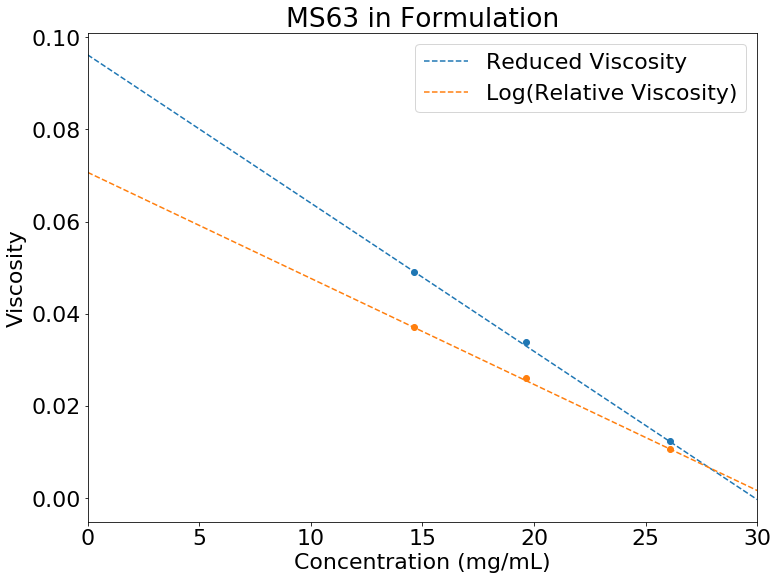

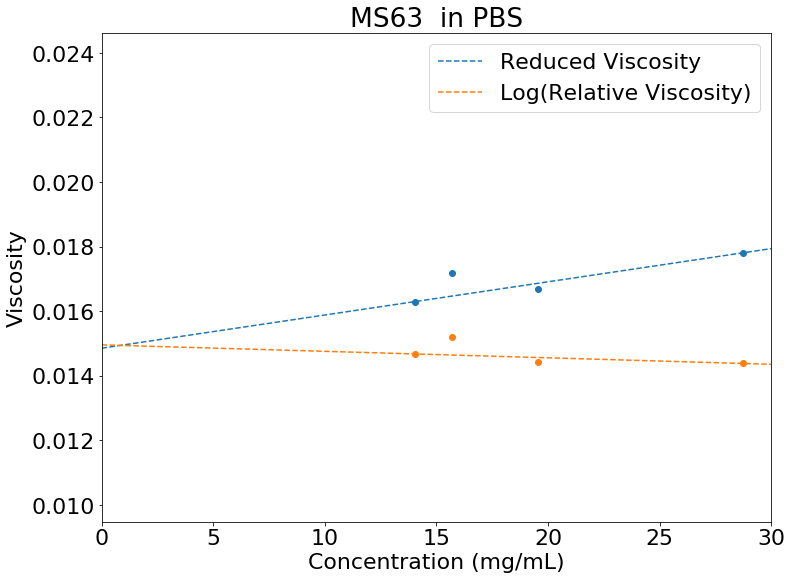

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

In [0]:
warnings.simplefilter('ignore', np.RankWarning)

curves_dictionary = {
        "Molecules" : [],
        "Buffers" : [],
        "Concentrations" : [],
        "Viscosities" : []
    }

for key, value in curves.iteritems():
    if(~np.isnan(np.sum(value[1:]))):
        if(str(value[0]) == "C (mg/mL)"):
            curves_dictionary["Molecules"].append(key)
            curves_dictionary["Concentrations"].append(np.asarray(value[1:]))
        elif(str(value[0]) == "V (cP)"):
            curves_dictionary["Buffers"].append(key)
            curves_dictionary["Viscosities"].append(np.asarray(value[1:]))
            
allcurves = []

for y in range(len(curves_dictionary["Buffers"])):
    concentrations = curves_dictionary["Concentrations"][y]
    concentrations = [x for x in concentrations if str(x) != 'nan']
    
    viscosities = curves_dictionary["Viscosities"][y]
    viscosities = [x for x in viscosities if str(x) != 'nan']

    molecule = curves_dictionary["Molecules"][y]
    mol,per,num = molecule.partition(".")
    
    buffer = curves_dictionary["Buffers"][y]
    buf,per,num = buffer.partition(".")
    
    index_buffer = -1

    for x in range(len(concentrations)):
        if(int(concentrations[x]) == 0):
            index_buffer = x

    if(len(concentrations) != len(viscosities)):
        print("Not a complete data set for {} in {}".format(mol,buf))
    elif(index_buffer == -1):
        print("Please measure the viscosity of {} in {}".format(mol,buf))
    else:
        curve = Curve(mol,buf,concentrations,viscosities)
        allcurves.append(curve)
        plt.figure()

In [0]:
i = 0
while i < len(allcurves):
    x = allcurves[i]
    if(len(x.low_range_visc)<3):
        print("Removed {} in {} because there are not enough low concentrations measurements - Requires 3 data points".format(x.molecule,x.buffer))
        allcurves.remove(x)
    else:
        i += 1

Removed Trapp in Formulation because there are not enough low concentrations measurements - Requires 3 data points
Removed PGT121 in PBS because there are not enough low concentrations measurements - Requires 3 data points
Removed PGDM1400 in PBS because there are not enough low concentrations measurements - Requires 3 data points
Removed mAB10 in PBS because there are not enough low concentrations measurements - Requires 3 data points
Removed MS63 - CS in PBS because there are not enough low concentrations measurements - Requires 3 data points


### 5. Calculate Huggins Constants

Developped as an indicator of how good a solvent is for a particular polymer, the Huggins constant contains info about hydro- and thermo-dynamic interactions between coils in solution. There is not much literature on the correlation between the Huggins constant and behavior in proteins.

https://www.eng.yale.edu/polymers/docs/classes/polyphys/lecture_notes/5/handout5_wsu3.html

In [0]:
huggins = {}

for x in allcurves:
    slope = fit(x.concentrations,x.viscosities,"","",Print=False)[0]
    huggins["{} in {}".format(x.molecule,x.buffer)] = slope/(x.intrinsic_visc**2)    
    
for key,value in huggins.items():
    print(key,":",round(value,1))

MS63 in Formulation : 18.5
MS63  in PBS : 3753.0


### 6. Tabulate Intrinsic Viscosities

Tabulates the intrinsic viscosity for every single curve. 

In [0]:
for x in allcurves:
    print("{} in {}".format(x.molecule,x.buffer),":",x.intrinsic_visc, "mL/mg")

MS63 in Formulation : 0.08345810721703453 mL/mg
MS63  in PBS : 0.014905873451625395 mL/mg


### 7. Plot Experimental Data and/or Best Fit

Plots the curve for EVERY dataset on the same plot. In order to hide either the fit curve or the experimental data, comment out the line by placing a # at the beginning of the line

MS63 in Formulation:
Fit Solvent Viscosity: 0.9230000000000002cP
Fit Packing Param:0.0014625000000000003
Fit Intrinsic Viscosity: 0.07345810721703455ml/mg

MS63  in PBS:
Fit Solvent Viscosity: 0.9250000000139508cP
Fit Packing Param:0.0016624999995221343
Fit Intrinsic Viscosity: 0.013857877490188053ml/mg



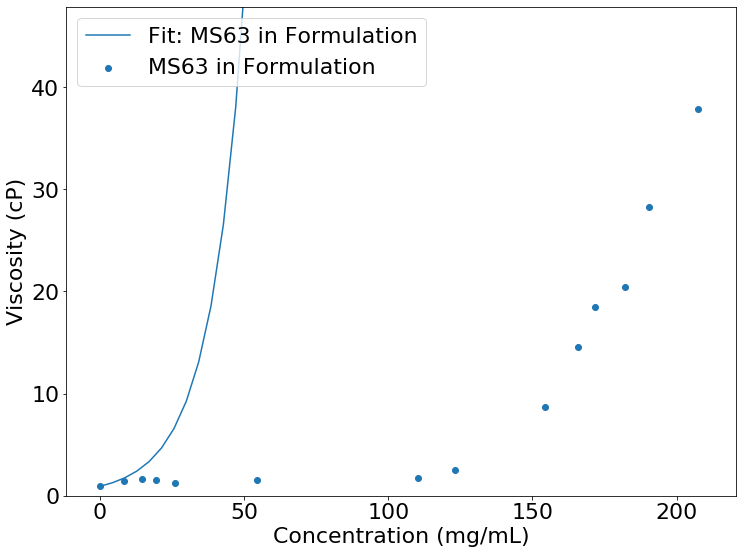

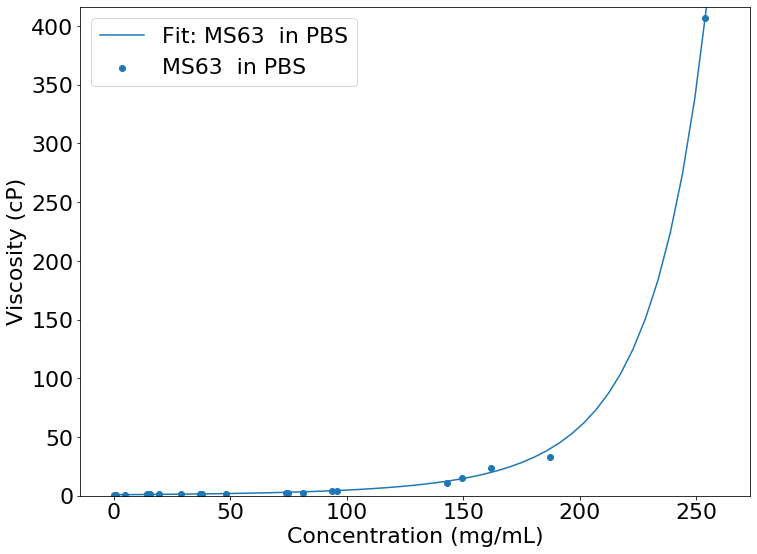

<Figure size 864x648 with 0 Axes>

In [0]:
for x in allcurves:
    x.generate_fit(True)
    x.experimental()
    plt.figure()

### 8. Generate Model

Generates two independent models, Mooney and Krieger-Dougherty, for EVERY dataset on one plot:

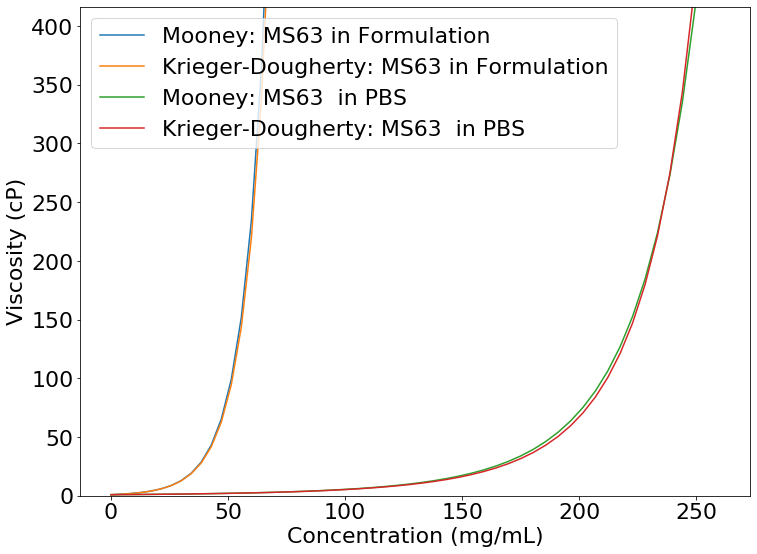

In [0]:
for x in allcurves:
    x.generate_model()

### 9. Put It All Together

Combines the model and experimental fit on one plot for each molecule/buffer combination individually

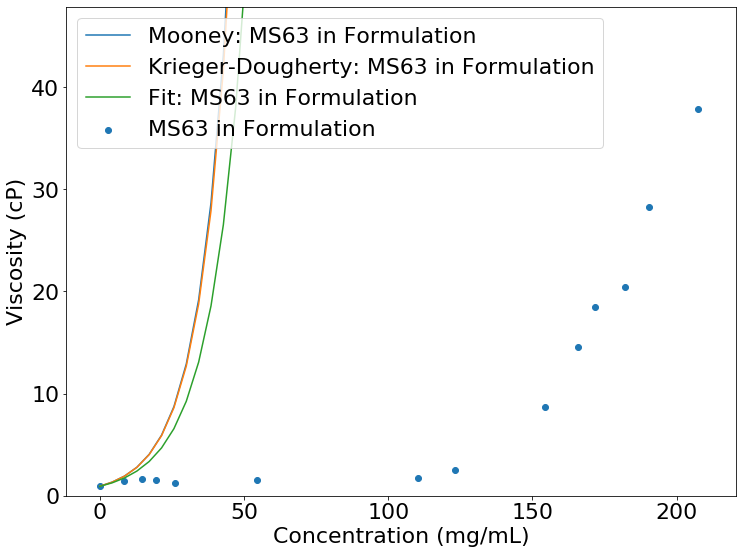

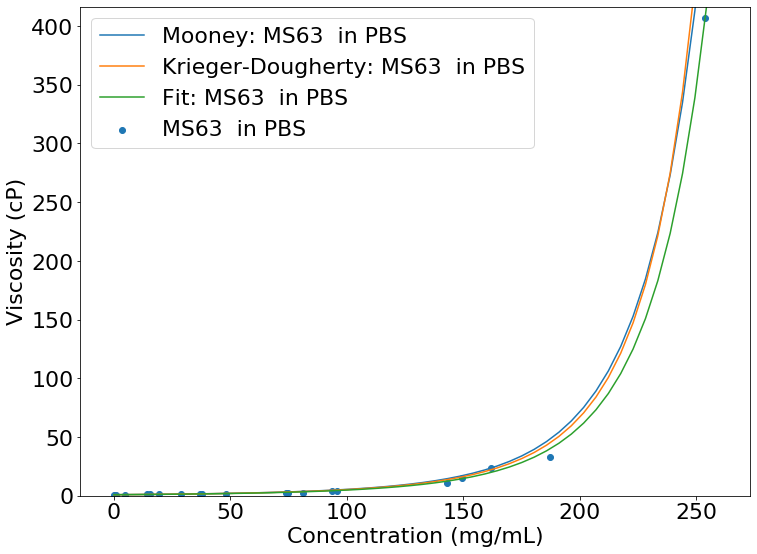

<Figure size 864x648 with 0 Axes>

In [0]:
for x in allcurves:
    x.generate_model()
    x.generate_fit()
    x.experimental()
    plt.figure()

### 10. Ranking Molecules

Produces two table to compare  the molecules based on several factors. The table can include raw data by setting rank=False, or can rank the molecules by setting rank=True.

An additional row tells you whether the highest or lowest value is indicative of an inviscid molecule.

<pre>
Intrinsic Visc: The intrinsic viscosity for the molecule in mL/mg
10cP or 15cP: The concentration in mg/mL of antibody correlating to the listed viscosity
150mg/mL or 175mg/mL or 200mg/mL: The predicted viscosity in cP at the listed concentration
</pre>

In [0]:
tabulate(allcurves, rank=True)

+---------------------+----------------+--------------+------------+------------------+----------------+
|                     | Intrinsic Visc | 10cP (Model) | 10cP (Exp) | 150mg/mL (Model) | 150mg/mL (Exp) |
+---------------------+----------------+--------------+------------+------------------+----------------+
|      Best Value     |     Lowest     |   Highest    |  Highest   |      Lowest      |     Lowest     |
| MS63 in Formulation |       1        |      0       |     0      |        1         |       1        |
|     MS63  in PBS    |       0        |      1       |     1      |        0         |       0        |
+---------------------+----------------+--------------+------------+------------------+----------------+
+---------------------+--------------+------------+------------------+----------------+------------------+----------------+
|                     | 15cp (Model) | 15cp (Exp) | 175mg/mL (Model) | 175mg/mL (Exp) | 200mg/mL (Model) | 200mg/mL (Exp) |
+----------------

### 11. Low Concentration Data Testing

In [0]:
curve = allcurves[1]


conc = curve.concentrations
visc = curve.viscosities
lowvisc = curve.low_range_visc
lowconc = curve.low_range_conc

solvisc = curve.solvisc
w=0.0016625

chi = []

for x in range (3,(len(lowvisc)+1)):
    conc_subsets = list(itertools.combinations(lowconc,x))
    visc_subsets = list(itertools.combinations(lowvisc,x))
    
    
    for y in range(len(conc_subsets)):
        
        v = visc_subsets[y]
        c = conc_subsets[y]
        
        rel_visc = []
        red_visc = []
        log_rel_visc = []
    
        for x in range(len(v)):
            rel_visc.append(v[x]/solvisc)
            red_visc.append((rel_visc[x]-1)/c[x])
            log_rel_visc.append(np.log(rel_visc[x])/c[x])

        
        intvisc1 = fit_rob(c,red_visc,"","",Print = False)
        intvisc2 = fit_rob(c,log_rel_visc,"","",Print = False)
        intvisc = (intvisc1+intvisc2)/2
        
        if intvisc < 0.014 and intvisc > 0.0136:
            y_model = model(visc,solvisc,w,intvisc)
            #plt.scatter(conc,visc)
            plt.plot(visc,y_model,label = intvisc)
            #plt.ylim(0,120)
            plt.legend()
            plt.show()
          
         
#          chisq = scipy.stats.chisquare(conc,y_model)
#          if chisq[1] > 0.05:
#              chi.append(chisq[0])
        
# print(chi)       

### 12. Sensitivity Testing

The NeoVISC has an inherent variability of 10%. This section examines the ability of the modelling system to work with error at or below that level. By contrast, the standard deviation in initium measurements is 0.16-0.26%

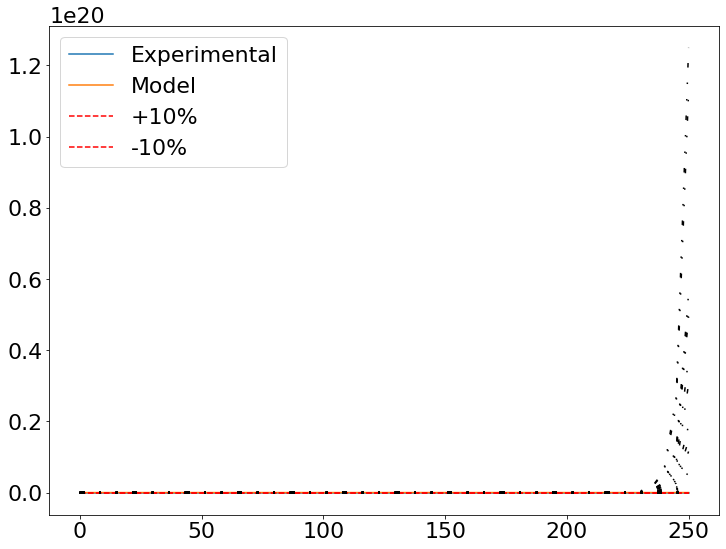

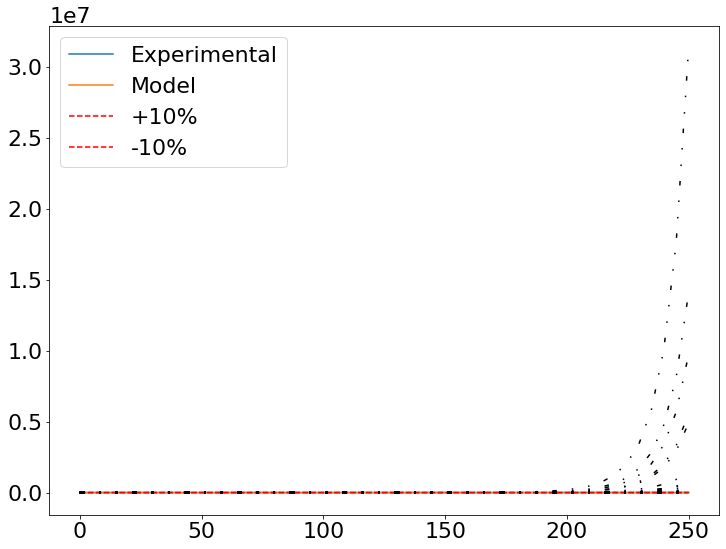

<Figure size 864x648 with 0 Axes>

In [0]:
error = 0.1


c = np.linspace(0,250)

for x in allcurves:
    
    real_visc = model(c,*x.fitvars)
    og_model = model(c,x.solvisc,(1/640),x.intrinsic_visc)
    plus10 = (1.1)*model(c,*x.fitvars)
    minus10 = (0.9)*model(c,*x.fitvars)
    
    plt.plot(c,real_visc,label="Experimental")
    plt.plot(c,og_model,label="Model")
    plt.plot(c,plus10,'r--',label="+10%")
    plt.plot(c,minus10, 'r--',label="-10%")
    
    plt.legend()
    
    for i in range(100):
        randvisc = []

        upper = int((1+error)*10000)
        lower = int((1-error)*10000)

        for y in range(len(x.viscosities)):
            randvisc.append((float(random.randrange(lower,upper))/10000)*x.viscosities[y])

        randomname = "Random:" + x.molecule
        rand_curve = Curve(randomname,x.buffer,x.concentrations,randvisc,Print = False)


        rand_model = model(c,rand_curve.solvisc,(1/640),rand_curve.intrinsic_visc)
        plt.plot(c,rand_model,linestyle=(0, (3, 10, 1, 10, 1, 10)),color="black",alpha=1)
    
    plt.figure()
#     nil = real_visc-real_visc
#     plt.plot(c,nil,label="Experimental Fit")
#     plt.plot(c,og_model,label="Original model")
#     plt.plot(c,upper_model,label="Upper model")
#     plt.plot(c,lower_model,label="Lower model")
#     plt.plot(c,rand_model,label="Random")